# Import Statements

In [2]:
import pandas as pd
import numpy as np
import sqlite3
from matplotlib import pyplot as plt
import dominate
from dominate.tags import *
import espn_api.football
from espn_api.football import League
import time
import pickle
import uuid

from python import constants

# Read the ESPN API to add to Dataset

### Fetch all League and Matchup data via api and save to pickle

In [130]:
leagues = []
matchups = []

for year in range(2019,2025):
    league = League(league_id=league_id, year=year, espn_s2=espn_s2, swid=swid)
    leagues.append(
        {
            'Year':year,
            'League':league
        }
    )

    season_length = 17
    if year in [2019,2020]:
        season_length = 16

    for week in range(1,season_length + 1):
        box_scores = league.box_scores(week)
        matchups.append(
            {
                'Year':year,
                'Week':week,
                'Box Scores':box_scores
            }
        )

        time.sleep(3)
        
data = {
    'Leagues':leagues,
    'Box Scores':matchups
}

In [140]:
with open('espn-api-2019-2024.pkl', 'wb') as file:
    pickle.dump(data, file)

In [22]:
with open('database/espn-data.pkl', 'rb') as file:
    data_new = pickle.load(file)

In [ ]:
import requests
import json

year = 2024

url = f'https://lm-api-reads.fantasy.espn.com/apis/v3/games/ffl/seasons/{year}/segments/0/leagues/{constants.LEAGUE_ID}'

filters = {
    "transactions": {
        "filterType": {
            "value": [
                'DRAFT',
                'FREEAGENT',
                'FUTURE_ROSTER',
                'RETRO_ROSTER',
                'ROSTER',
                'TRADE_ACCEPT',
                'TRADE_ERROR',
                'TRADE_PROPOSAL',
                'TRADE_UPHOLD',
                'TRADE_VETO',
                'WAIVER',
                'WAIVER_ERROR'
            ]
        }
    }
}

headers = {
    "x-fantasy-filter": json.dumps(filters)
}

cookies = {
    'espn_s2':constants.ESPN_S2,
    'SWID':constants.SWID
}

params = {
    'view':'mTransactions2',
    'scoringPeriodId':8
}

r = requests.get(url, params=params, headers=headers, cookies=cookies)
data = r.json()


In [215]:
for record in data.get('transactions'):
    print(
        record['id'],
        record['items'][0]['playerId'],
        record['proposedDate'],
        record['executionType'],
        record['type'],
        record['status']
    )

3af2bcf0-ef76-45c1-9deb-cd8ba2e0812c 2985659 1729828438622 EXECUTE FREEAGENT EXECUTED
d554bf8b-ccab-42b5-a67f-70d8fa3929a1 14881 1729671026271 PROCESS WAIVER EXECUTED
91325026-6d46-42aa-b561-81bd2c11ce3c 4428209 1729671026271 PROCESS WAIVER EXECUTED
4291610c-7231-4b9a-be96-4e0f1642ed1e 4567104 1729671026271 PROCESS WAIVER EXECUTED
1ae7ea58-693e-4bc8-b401-82bd0cec2264 2977187 1729512780439 EXECUTE FUTURE_ROSTER EXECUTED
6b36c8c7-7196-4bb5-a293-9a76cec54842 4047365 1729560521948 EXECUTE FUTURE_ROSTER EXECUTED
fb84c216-1b02-49a0-9671-c0bba298d6a0 4430834 1729613926068 CANCEL WAIVER CANCELED
3966c1fd-b052-4f89-b7c7-4da62fc3c91b 4428209 1729626780073 CANCEL WAIVER CANCELED
cc990ade-0989-4159-9cb2-c2cedb0d9222 4430834 1729671026271 PROCESS WAIVER FAILED_INVALIDPLAYERSOURCE
d3dad0de-8056-4e17-a422-f64518b6b3df 4430834 1729671026271 PROCESS WAIVER FAILED_INVALIDPLAYERSOURCE
fe3b51c3-e283-4e71-a1b6-243cebacfdf3 4635008 1729568783495 EXECUTE FUTURE_ROSTER EXECUTED
7ff5b480-6e14-4f76-9e12-da838db

In [32]:
espn_api.football.constant.TRANSACTION_TYPES

{'DRAFT',
 'FREEAGENT',
 'FUTURE_ROSTER',
 'RETRO_ROSTER',
 'ROSTER',
 'TRADE_ACCEPT',
 'TRADE_DECLINE',
 'TRADE_ERROR',
 'TRADE_PROPOSAL',
 'TRADE_UPHOLD',
 'TRADE_VETO',
 'WAIVER',
 'WAIVER_ERROR'}

In [22]:
league = League(league_id=constants.LEAGUE_ID, year=2023, espn_s2=constants.ESPN_S2, swid=constants.SWID)
data_transactions = []
for week in range(17):
    try:
        week_transactions = league.transactions(week, types={
        'DRAFT',
        'FREEAGENT',
        'FUTURE_ROSTER',
        'RETRO_ROSTER',
        'ROSTER',
        'TRADE_ACCEPT',
        'TRADE_ERROR',
        'TRADE_PROPOSAL',
        'TRADE_UPHOLD',
        'TRADE_VETO',
        'WAIVER',
        'WAIVER_ERROR'
        })
    except:
        continue
    for trans in week_transactions:
        data_transactions.append(trans)
        
for i in range(len(data_transactions)):
    if 'TRADE' in data_transactions[i].type:
        print(i, data_transactions[i].items, data_transactions[i].type, data_transactions[i].status)

206 [TRADE Skyy Moore, TRADE Ezekiel Elliott] TRADE_PROPOSAL PENDING
222 [TRADE Skyy Moore, TRADE Ezekiel Elliott] TRADE_PROPOSAL CANCELED
316 [TRADE Gus Edwards, TRADE Trevor Lawrence, TRADE Trey McBride, TRADE Lamar Jackson] TRADE_ACCEPT EXECUTED


In [31]:
league = League(league_id=constants.LEAGUE_ID, year=2019, espn_s2=constants.ESPN_S2, swid=constants.SWID)
print({
    'first_week':league.firstScoringPeriod,
    'last week':league.finalScoringPeriod,
    'seasons':league.previousSeasons
})

{'first_week': 1, 'last week': 16, 'seasons': [2018]}


In [277]:
df = pd.DataFrame([vars(record) for record in data_transactions])
df
df.loc[(df['type'] == 'TRADE_ACCEPT') | (df['type'] == 'TRADE_PROPOSAL')]
# df['type'].unique()
# df.loc[(df['status'] == 'PENDING')]

,team,type,status,scoring_period,date,bid_amount,items
3,Team(i like the cowboys),TRADE_PROPOSAL,CANCELED,1,NaN,0,"[TRADE Rome Odunze, TRADE Ezekiel Elliott]"
54,Team(McBridesmaids),TRADE_PROPOSAL,CANCELED,1,NaN,0,"[TRADE George Pickens, TRADE Brian Robinson Jr..."
91,Team(McBridesmaids),TRADE_PROPOSAL,CANCELED,1,NaN,0,"[TRADE Davante Adams, TRADE Marvin Harrison Jr.]"
176,Team(i like the cowboys),TRADE_PROPOSAL,PENDING,1,NaN,0,"[TRADE Rome Odunze, TRADE Ezekiel Elliott]"
221,Team(Michaels Avg. Team),TRADE_PROPOSAL,CANCELED,2,NaN,0,"[TRADE Brandin Cooks, TRADE Dalton Kincaid, TR..."
223,Team(Michaels Avg. Team),TRADE_PROPOSAL,PENDING,2,NaN,0,"[TRADE Brandin Cooks, TRADE Dalton Kincaid, TR..."
463,Team(Pukie Bear),TRADE_ACCEPT,EXECUTED,14,1.733213e+12,0,"[TRADE Alexander Mattison, TRADE Jameson Willi..."


In [280]:
league.player_map.get(3045147)

'James Conner'

In [180]:
efr = espn_api.requests.espn_requests.EspnFantasyRequests(
    sport='nfl',
    year=2024,
    league_id=constants.LEAGUE_ID,
    cookies=cookies
)

data2 = efr.league_get(params=params, headers=headers)
for record in data2.get('transactions'):
    print(
        record['id'],
        record['executionType'],
        record['type'],
        record['status']
    )


3af2bcf0-ef76-45c1-9deb-cd8ba2e0812c EXECUTE FREEAGENT EXECUTED
d554bf8b-ccab-42b5-a67f-70d8fa3929a1 PROCESS WAIVER EXECUTED
91325026-6d46-42aa-b561-81bd2c11ce3c PROCESS WAIVER EXECUTED
4291610c-7231-4b9a-be96-4e0f1642ed1e PROCESS WAIVER EXECUTED
fb84c216-1b02-49a0-9671-c0bba298d6a0 CANCEL WAIVER CANCELED
3966c1fd-b052-4f89-b7c7-4da62fc3c91b CANCEL WAIVER CANCELED
cc990ade-0989-4159-9cb2-c2cedb0d9222 PROCESS WAIVER FAILED_INVALIDPLAYERSOURCE
d3dad0de-8056-4e17-a422-f64518b6b3df PROCESS WAIVER FAILED_INVALIDPLAYERSOURCE
d0cb7814-ef14-45b4-bff0-65c48581fdec CANCEL WAIVER CANCELED
609f90f0-f9c1-479f-ab6a-57ab792be3d0 EXECUTE FREEAGENT EXECUTED
1c675970-dc54-4b15-ad73-269d288aa865 PROCESS WAIVER EXECUTED
a1b4fdc4-1dc8-4bfd-b1c5-958c7124f33a PROCESS WAIVER FAILED_INVALIDPLAYERSOURCE
0ea8d5e5-f403-4c5e-941f-59b65d398c66 EXECUTE FREEAGENT EXECUTED
fab26119-7927-47f1-aaf5-bb4d4e762554 PROCESS WAIVER EXECUTED
3955fc95-faee-4ed2-97c7-e02bfb48f03b EXECUTE FREEAGENT EXECUTED
a98317dc-757b-4bfa-8f2

In [21]:
NAMESPACE = uuid.UUID('05859822-9e6e-4612-91ff-c714fa7e40f6')

In [66]:
league = data_new['Leagues'][0]['League']
d = league.player_map
d.keys()
ddd = [{'player_id':str(uuid.uuid5(namespace=NAMESPACE, name=player)), 'player_name':player} for player in d.keys() if type(player) == str]

pd.DataFrame(ddd)

,player_id,player_name
0,13d7d9bd-f58b-570b-9191-bb0169a1432a,Fozzy Whittaker
1,82f25517-9855-5b94-acaf-279102b63e1a,D'Andre Walker
2,dbbc604e-2fd6-534d-a36f-d16d38a7df39,Tye Smith
3,42aa22dd-be96-544f-b90f-51dad33a0558,Roquan Smith
4,3fc205b6-c96f-55a7-92e6-1479feaa88c4,Darren Fells
...,...,...
2626,9305b417-a8d0-5ea9-a24d-c109ed897133,Josh Gordon
2627,e9fa747b-aade-5675-be3f-323806da746b,Jordan Scarlett
2628,76147238-79c3-5b1a-a2b9-1f4fbfd9dcdb,Jared Goff
2629,91ac2f31-c6ed-54da-91bf-e8cb18ab1fed,Antonio Callaway


### Create Teams + Drafts Dataframes

In [84]:
data_teams = []
data_drafts = []
data_players = []

leagues = data_new['Leagues']
for record in leagues:
    league = record['League']
    year = record['Year']

    for player in league.player_map.keys():
        if type(player) == int:
            continue
        data_players.append(player)

    for pick in league.draft:
        team_name = pick.team.owners[0]['firstName']
        if team_name == 'The':
            team_name = 'Klapp'
        elif team_name == 'Noah ':
            team_name = 'Noah'

        data_drafts.append(
            {
                'draft_pick_id':str(uuid.uuid4()),
                'player_id':str(uuid.uuid5(namespace=NAMESPACE, name=pick.playerName)),
                'team_id':str(uuid.uuid5(namespace=NAMESPACE, name=team_name)),
                'year':year,
                'round':pick.round_num,
                'pick':pick.round_pick
            }
        )

    for team in league.teams:
        team_name = team.owners[0]['firstName']
        if team_name == 'The':
            team_name = 'Klapp'
        elif team_name == 'Noah ':
            team_name = 'Noah'

        data_teams.append(team_name)

data_teams = [{'team_id':str(uuid.uuid5(namespace=NAMESPACE, name=team)), 'team_name':team} for team in list(set(data_teams))]
df_teams = pd.DataFrame(data_teams)

data_players = [{'player_id':str(uuid.uuid5(namespace=NAMESPACE, name=player)), 'player_name':player} for player in list(set(data_players))]
df_players = pd.DataFrame(data_players)

df_drafts = pd.DataFrame(data_drafts)

### Create Matchups + Games + Player Games + Players Dataframes

In [83]:
data_matchups = []
data_games = []
data_player_games = []
data_players = []

box_scores = data_new['Box Scores']
for box_score in box_scores:
    year = box_score['Year']
    week = box_score['Week']
    matchups = box_score['Box Scores']

    for matchup in matchups:
        matchup_id = str(uuid.uuid4())

        home_team = matchup.home_team.owners[0]['firstName']
        if home_team == 'The':
            home_team = 'Klapp'
        elif home_team == 'Noah ':
            home_team = 'Noah'

        if matchup.away_team == 0:
            away_team = 'Bye'
        else:
            away_team = matchup.away_team.owners[0]['firstName']
        if away_team == 'The':
            away_team = 'Klapp'
        elif away_team == 'Noah ':
            away_team = 'Noah'

        data_matchups.append(
            {
                'matchup_id':matchup_id,
                'year':year,
                'week':week,
                'matchup_type':matchup.matchup_type,
                'playoff_flag':matchup.is_playoff,
                'home_team_id':str(uuid.uuid5(NAMESPACE, name=home_team)),
                'home_score':matchup.home_score,
                'away_team_id':str(uuid.uuid5(NAMESPACE, name=away_team)),
                'away_score':matchup.away_score
            }
        )

        home_game_id = str(uuid.uuid4())
        data_games.append(
            {
                'game_id':home_game_id,
                'matchup_id':matchup_id,
                'team_id':str(uuid.uuid5(NAMESPACE, name=home_team)),
                'score':matchup.home_score,
                'opp_score':matchup.away_score,
                'win_flag':int(matchup.home_score > matchup.away_score),
                'margin':round(matchup.home_score - matchup.away_score, 2)
            }
        )

        away_game_id = str(uuid.uuid4())
        data_games.append(
            {
                'game_id':away_game_id,
                'matchup_id':matchup_id,
                'team_id':str(uuid.uuid5(NAMESPACE, name=away_team)),
                'score':matchup.away_score,
                'opp_score':matchup.home_score,
                'win_flag':int(matchup.away_score > matchup.home_score),
                'margin':round(matchup.away_score - matchup.home_score, 2)
            }
        )

        for player in matchup.home_lineup:
            data_player_games.append(
                {
                    'player_game_id':str(uuid.uuid4()),
                    'matchup_id':matchup_id,
                    'game_id':home_game_id,
                    'team_id':str(uuid.uuid5(NAMESPACE, name=home_team)),
                    'player_id':str(uuid.uuid5(NAMESPACE, name=player.name)),
                    'points':player.points,
                    'slot_position':player.slot_position,
                    'active_status':player.active_status,
                    'bye_week_flag':player.on_bye_week
                }
            )

        for player in matchup.away_lineup:
            data_player_games.append(
                {
                    'player_game_id':str(uuid.uuid4()),
                    'game_id':away_game_id,
                    'matchup_id':matchup_id,
                    'team_id':str(uuid.uuid5(NAMESPACE, name=away_team)),
                    'player_id':str(uuid.uuid5(NAMESPACE, name=player.name)),
                    'points':player.points,
                    'slot_position':player.slot_position,
                    'active_status':player.active_status,
                    'bye_week_flag':player.on_bye_week
                }
            )

        for player in (matchup.home_lineup + matchup.away_lineup):
            data_players.append(player.name)


df_matchups = pd.DataFrame(data_matchups)
df_games = pd.DataFrame(data_games)
df_player_games = pd.DataFrame(data_player_games)

### API to grab every single player that was started for each team

In [ ]:
data_game = []
data_matchup = []
data_team = []
for year in range(2019,2025):
    
    league = League(league_id=league_id, year=year, espn_s2=espn_s2, swid=swid)
    team_dict = {team:team.owners[0]['firstName'] for team in league.teams}
    team_dict[0] = 'Bye'

    season_length = 17
    if year in [2019,2020]:
        season_length = 16

    for week in range(1,season_length + 1):
        matchups = league.box_scores(week)
        for game in matchups:

            data_matchup.append(
                {
                    'Year':year,
                    'Week':week,
                    'Matchup Type':game.matchup_type,
                    'Playoff Flag':game.is_playoff,
                    'Home Team':team_dict[game.home_team],
                    'Home Score':game.home_score,
                    'Away Team':team_dict[game.away_team],
                    'Away Score':game.away_score
                }
            )

            team = team_dict[game.home_team]
            for player in game.home_lineup:
                if player.slot_position != 'BE':
                    data_game.append(
                        {
                            'Year':year,
                            'Week':week,
                            'Team':team,
                            'Player Name':player.name,
                            'Points Scored':player.points,
                            'Slot Position':player.slot_position
                        }
                    )

            team = team_dict[game.away_team]
            for player in game.away_lineup:
                if player.slot_position != 'BE':
                    data_game.append(
                        {
                            'Year':year,
                            'Week':week,
                            'Team':team,
                            'Player Name':player.name,
                            'Points Scored':player.points,
                            'Slot Position':player.slot_position
                        }
                    )

df_matchup = pd.DataFrame(data_matchup)
print(df_matchup.shape)

df_game = pd.DataFrame(data_game)
#df_game.to_csv('fantasy-football-player-data.csv')
print(df_game.shape)

df_team = pd.DataFrame(data_team)
print(df_team.shape)

(10131, 5)
(6, 1)


In [123]:
k = league.box_scores(1)

In [ ]:
import uuid

data_matchup = []
data_game = []
data_player = []

team_dict = {team:team.owners[0]['firstName'] for team in league.teams}
team_dict[0] = 'Bye'

matchups = league.box_scores(8)
for matchup in matchups:
    matchup_id = str(uuid.uuid4())
    data_matchup.append(
        {
            'Matchup ID':matchup_id,
            'Year':year,
            'Week':week,
            'Matchup Type':matchup.matchup_type,
            'Playoff Flag':matchup.is_playoff,
            'Home Team':team_dict[matchup.home_team],
            'Home Score':matchup.home_score,
            'Away Team':team_dict[matchup.away_team],
            'Away Score':matchup.away_score
        }
    )

    home_game_id = str(uuid.uuid4())
    data_game.append(
        {
            'Game ID':home_game_id,
            'Team':team_dict[matchup.home_team],
            'Score':matchup.home_score,
            'Opp Score':matchup.away_score
        }
    )

    away_game_id = str(uuid.uuid4())
    data_game.append(
        {
            'Game ID':away_game_id,
            'Team':team_dict[matchup.away_team],
            'Score':matchup.home_score,
            'Opp Score':matchup.away_score
        }
    )

    team = team_dict[matchup.home_team]
    for player in matchup.home_lineup:
        data_player.append(
            {
                'Game ID':home_game_id,
                'Matchup ID':matchup_id,
                'Year':year,
                'Week':week,
                'Team':team,
                'Player Name':player.name,
                'Points Scored':player.points,
                'Slot Position':player.slot_position
            }
        )

    team = team_dict[matchup.away_team]
    for player in matchup.away_lineup:
        data_player.append(
            {
                'Player Game ID':
                'Game ID':away_game_id,
                'Matchup ID':matchup_id,
                'Year':year,
                'Week':week,
                'Team':team,
                'Player Name':player.name,
                'Points Scored':player.points,
                'Slot Position':player.slot_position
            }
        )

test_matchup = pd.DataFrame(data_matchup)
test_player = pd.DataFrame(data_player)
test_matchup

,Matchup ID,Year,Week,Matchup Type,Playoff Flag,Home Team,Home Score,Away Team,Away Score
0,907a7e3d-564c-477b-a6f4-de81eb35c606,2024,17,WINNERS_BRACKET,True,Kevin,103.26,Bye,0.00
1,4a21f734-e2c1-4346-8beb-37558e896aef,2024,17,WINNERS_BRACKET,True,Dante,150.24,Zach,153.82
2,c0439a56-17cc-403c-8df5-bf59c0fcedc8,2024,17,WINNERS_BRACKET,True,Carter,105.18,Noah,119.10
3,e645d699-c9f3-40ab-a0a1-04c5cfe99f4e,2024,17,WINNERS_BRACKET,True,Andrew,0.00,Bye,0.00
4,8204d052-674c-43ef-b7b2-6efc765f587f,2024,17,LOSERS_CONSOLATION_LADDER,True,Tyler,109.08,Ethan,99.66
5,9d79d882-70f6-478b-a6e2-3bf4ad8b736e,2024,17,LOSERS_CONSOLATION_LADDER,True,Nathan,114.54,Haris,112.66
6,42fcf2c6-d6d6-47be-a775-0661ac95c4e1,2024,17,LOSERS_CONSOLATION_LADDER,True,Michael,171.96,McGwire,57.64


In [ ]:
test_player

,Game ID,Matchup ID,Year,Week,Team,Player Name,Points Scored,Slot Position
0,2934feaf-3b09-4218-8630-38fb03e10f91,907a7e3d-564c-477b-a6f4-de81eb35c606,2024,17,Kevin,Bijan Robinson,14.50,RB
1,d4839b6c-84b3-4bf5-8a37-96f11243bb3a,907a7e3d-564c-477b-a6f4-de81eb35c606,2024,17,Kevin,Kyren Williams,13.20,RB
2,3d69d276-a2d0-4b66-bed3-0df2ce75f6ad,907a7e3d-564c-477b-a6f4-de81eb35c606,2024,17,Kevin,Deebo Samuel Sr.,4.90,WR
3,11b193b8-a8a7-4c65-a1e3-904047e09a65,907a7e3d-564c-477b-a6f4-de81eb35c606,2024,17,Kevin,Tee Higgins,19.80,WR
4,f364c1c9-f392-43a0-a89d-e2f1bcded686,907a7e3d-564c-477b-a6f4-de81eb35c606,2024,17,Kevin,Jordan Love,17.56,QB
...,...,...,...,...,...,...,...,...
95,9acb5b95-a5c7-4404-a7d5-5ccb17ab69dc,42fcf2c6-d6d6-47be-a775-0661ac95c4e1,2024,17,McGwire,Justin Tucker,5.00,K
96,90609ca1-9831-4aeb-b639-5e3d010af9bb,42fcf2c6-d6d6-47be-a775-0661ac95c4e1,2024,17,McGwire,T.J. Hockenson,10.20,RB/WR/TE
97,3bf63efb-a154-453d-b630-ca98580c1662,42fcf2c6-d6d6-47be-a775-0661ac95c4e1,2024,17,McGwire,Tua Tagovailoa,3.84,QB
98,6cf37ec0-0beb-468f-ba5b-b05d273f12e6,42fcf2c6-d6d6-47be-a775-0661ac95c4e1,2024,17,McGwire,Chargers D/ST,-4.00,D/ST


In [319]:
df.loc[(df['Playoff Flag']) & (df['Year'] == 2020)]

,Year,Week,Playoff Flag,Home Team,Home Score,Home Projection,Away Team,Away Score,Away Projection
150,2020,14,True,Ethan,96.42,133.03,Bye,0.00,0.00
151,2020,14,True,Noah,140.68,143.30,Andrew,123.42,124.52
152,2020,14,True,Dante,119.14,127.12,Carter,103.16,123.76
153,2020,14,True,Michael,95.06,110.21,Bye,0.00,0.00
154,2020,15,True,Ethan,145.76,126.16,Noah,133.16,143.99
155,2020,15,True,Michael,144.32,121.74,Dante,119.24,120.18
156,2020,16,True,Ethan,143.14,143.14,Michael,100.96,100.96


# Constant Files + Helper Functions

In [10]:
MATCHUP_DATA = pd.read_csv('database/fantasy-football-matchup-data.csv')
GAME_DATA = pd.read_csv('database/fantasy-football-game-data.csv')
TEAMS = GAME_DATA.loc[GAME_DATA['Playoff Flag'] == 0, 'Team'].unique()
YEARS = GAME_DATA['Year'].unique()
YEARS_WEEKS = [(year, GAME_DATA.loc[(GAME_DATA['Year'] == year) & (GAME_DATA['Playoff Flag'] == False), 'Week'].max()) for year in YEARS]

COLOR_DICT = {'andrew':'cornflowerblue',
              'mcgwire':'darkblue',
              'tyler':'lightgreen',
              'noah':'#33a02c',
              'michael':'#fb9a99',
              'haris':'#e31a1c',
              'dante':'sandybrown',
              'nathan':'#ff7f00',
              'kevin':'violet',
              'ethan':'#6a3d9a',
              'zach':'gold',
              'carter':'#b15928',
              'justin':"#DA5CB4",
              'klapp':"#cec962"}

### Helper Functions (df_to_table, luck score functions)

In [4]:
def df_to_table(data: pd.DataFrame) -> table:
    t = table()
    head = thead()
    body = tbody()

    column_row = tr()
    for column in data.columns:
        column_row.add(th(column))
    head.add(column_row)
    
    for row in data.values:
        r = tr()
        for value in row:
            r.add(td(value))
        body.add(r)

    t.add(head)
    t.add(body)

    return t

def opp_luck_score(opp_score, mean=None, std=None):
    return int(((mean - opp_score) / np.absolute(mean - opp_score)) * np.floor(np.absolute(mean - opp_score) / std))

def your_luck_score(your_score, opp_score, mean=None, std=None):
    xi = lambda x: np.floor((mean + x) / (2*mean))
    result = int(your_score > opp_score)
    return int(np.floor(np.absolute(mean - your_score) / std) * (result * xi(2*mean - your_score) - (1-result) * xi(your_score)))
    
def close_luck_score(your_score, opp_score):
    close_game_flag = int(abs(your_score - opp_score) < 3)
    win_flag = int(your_score > opp_score)
    loss_flag = -int(your_score < opp_score)

    return (close_game_flag * win_flag) + (close_game_flag * loss_flag)

def summary_table(data: pd.DataFrame, year: int, week: int = None) -> pd.DataFrame:
    temp = data.loc[(data['Year'] == year) & (data['Playoff Flag'] == False)].copy()

    if week != None:
        temp = temp.loc[(data['Week'] <= week)]

    mean = temp['Score'].mean()
    std = temp['Score'].std() * 0.5

    opp_luck = []
    your_luck = []
    close_luck = []

    for your_score, opp_score in temp[['Score','Opp Score']].values:
        opp_luck.append(opp_luck_score(opp_score=opp_score, mean=mean, std=std))
        your_luck.append(your_luck_score(your_score=your_score, opp_score=opp_score, mean=mean, std=std))
        close_luck.append(close_luck_score(your_score=your_score, opp_score=opp_score))

    temp['Opp Luck Score'] = opp_luck
    temp['Your Luck Score'] = your_luck
    temp['Close Luck Score'] = close_luck

    temp['Luck Score'] = temp[['Opp Luck Score','Your Luck Score','Close Luck Score']].sum(axis=1)

    temp_teams = temp['Team'].unique()
    weekly_standings = []

    for team in temp_teams:
        temp_team = temp.loc[temp['Team'] == team]
        wins = temp_team['Win'].sum()
        losses = temp_team['Win'].eq(0).sum()
        record = f'{wins}-{losses}'

        pf = round(temp_team['Score'].sum(), 2)
        avg_pf = round(pf / len(temp_team), 2)
        pa = round(temp_team['Opp Score'].sum(), 2)
        avg_margin = round((pf - pa) / len(temp_team), 2)
        luck_score = temp_team['Luck Score'].sum()

        weekly_standings.append([team, wins, record, pf, pa, avg_pf, avg_margin, luck_score])

    weekly_standings = pd.DataFrame(weekly_standings, columns=['Team','Wins','Record', 'Points For','Points Against','Avg Points For','Avg Margin','Luck Score'])
    weekly_standings.sort_values(['Wins','Points For'], ascending=False, ignore_index=True, inplace=True)
    weekly_standings['Ranking'] = [i + 1 for i in weekly_standings.index]
    weekly_standings['Year'] = year
    weekly_standings = weekly_standings[['Year','Team','Record','Ranking','Points For','Points Against','Avg Points For','Avg Margin','Luck Score']]

    return weekly_standings

In [373]:
d = summary_table(GAME_DATA, year = 2023).drop('Year', axis = 1)
d

,Team,Record,Ranking,Points For,Points Against,Avg Points For,Avg Margin,Luck Score
0,Haris,12-2,1,1801.34,1456.30,128.67,24.65,10
1,Carter,11-3,2,1787.82,1538.86,127.70,17.78,9
2,Ethan,9-5,3,1574.82,1510.76,112.49,4.58,7
3,Andrew,8-6,4,1672.62,1532.50,119.47,10.01,2
4,Michael,8-6,5,1575.84,1666.08,112.56,-6.45,1
5,Kevin,7-7,6,1800.40,1696.42,128.60,7.43,-8
6,Noah,7-7,7,1579.60,1669.46,112.83,-6.42,-1
7,Dante,6-8,8,1689.52,1667.06,120.68,1.60,-6
8,Nathan,6-8,9,1496.26,1648.44,106.88,-10.87,4
9,Zach,4-10,10,1488.32,1699.04,106.31,-15.05,-4


# Week Content

## Weekly Scoreboard Table





In [102]:
year = 2022
week = 10

scoreboard = MATCHUP_DATA.loc[(MATCHUP_DATA['Year'] == year) & (MATCHUP_DATA['Week'] == week), ['Home Team','Home Score','Away Score','Away Team']]
scoreboard

,Home Team,Home Score,Away Score,Away Team
284,Kevin,117.68,102.70,Dante
285,Ethan,116.40,102.56,Andrew
286,Haris,102.34,139.04,Carter
287,Michael,123.00,88.60,Zach
288,Tyler,97.90,106.92,McGwire
289,Noah,122.48,104.38,Nathan


In [103]:
print(df_to_table(scoreboard))

<table>
  <thead>
    <tr>
      <th>Home Team</th>
      <th>Home Score</th>
      <th>Away Score</th>
      <th>Away Team</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Kevin</td>
      <td>117.68</td>
      <td>102.7</td>
      <td>Dante</td>
    </tr>
    <tr>
      <td>Ethan</td>
      <td>116.4</td>
      <td>102.56</td>
      <td>Andrew</td>
    </tr>
    <tr>
      <td>Haris</td>
      <td>102.34</td>
      <td>139.04</td>
      <td>Carter</td>
    </tr>
    <tr>
      <td>Michael</td>
      <td>123.0</td>
      <td>88.6</td>
      <td>Zach</td>
    </tr>
    <tr>
      <td>Tyler</td>
      <td>97.9</td>
      <td>106.92</td>
      <td>McGwire</td>
    </tr>
    <tr>
      <td>Noah </td>
      <td>122.48</td>
      <td>104.38</td>
      <td>Nathan</td>
    </tr>
  </tbody>
</table>


## Weekly Standings Update Table (with Luck Scores)

In [269]:
year = 2022
week = 2

temp = GAME_DATA.loc[(GAME_DATA['Year'] == year) & (GAME_DATA['Week'] <= week)].copy()

mean = temp['Score'].mean()
std = temp['Score'].std() * 0.5

opp_luck = []
your_luck = []
close_luck = []

for your_score, opp_score in temp[['Score','Opp Score']].values:
    opp_luck.append(opp_luck_score(opp_score=opp_score, mean=mean, std=std))
    your_luck.append(your_luck_score(your_score=your_score, opp_score=opp_score, mean=mean, std=std))
    close_luck.append(close_luck_score(your_score=your_score, opp_score=opp_score))

temp['Opp Luck Score'] = opp_luck
temp['Your Luck Score'] = your_luck
temp['Close Luck Score'] = close_luck

temp['Luck Score'] = temp[['Opp Luck Score','Your Luck Score','Close Luck Score']].sum(axis=1)

temp_teams = temp['Team'].unique()
weekly_standings = []

for team in temp_teams:
    temp_team = temp.loc[temp['Team'] == team]
    wins = temp_team['Win'].sum()
    losses = week - wins
    record = f'{wins}-{losses}'

    pf = round(temp_team['Score'].sum(), 2)
    avg_pf = round(pf / week, 2)
    pa = round(temp_team['Opp Score'].sum(), 2)
    avg_margin = round((pf - pa) / week, 2)
    luck_score = temp_team['Luck Score'].sum()

    weekly_standings.append([team, wins, record, pf, pa, avg_pf, avg_margin, luck_score])

weekly_standings = pd.DataFrame(weekly_standings, columns=['Team','Wins','Record', 'Points For','Points Against','Avg Points For','Avg Margin','Luck Score'])
weekly_standings.sort_values(['Wins','Points For'], ascending=False, ignore_index=True, inplace=True)
weekly_standings = weekly_standings[['Team','Record','Points For','Points Against','Avg Points For','Avg Margin','Luck Score']]
weekly_standings

,Team,Record,Points For,Points Against,Avg Points For,Avg Margin,Luck Score
0,Andrew,2-0,268.20,252.72,134.10,7.74,-1
1,Michael,2-0,255.34,191.04,127.67,32.15,3
2,Zach,2-0,235.66,203.68,117.83,15.99,1
3,Dante,2-0,225.26,167.96,112.63,28.65,5
4,Haris,1-1,280.22,248.36,140.11,15.93,-2
5,Noah,1-1,272.04,227.72,136.02,22.16,1
6,Carter,1-1,239.50,206.90,119.75,16.30,2
7,Kevin,1-1,228.08,270.58,114.04,-21.25,-3
8,McGwire,0-2,226.38,251.66,113.19,-12.64,-2
9,Ethan,0-2,204.16,265.74,102.08,-30.79,-2


# Year Content

#### Regular Season Final Standings Table (with Luck Scores)

In [9]:
year = 2023
standings = summary_table(GAME_DATA, year = year)
standings

,Year,Team,Record,Ranking,Points For,Points Against,Avg Points For,Avg Margin,Luck Score
0,2023,Haris,12-2,1,1801.34,1456.30,128.67,24.65,10
1,2023,Carter,11-3,2,1787.82,1538.86,127.70,17.78,9
2,2023,Ethan,9-5,3,1574.82,1510.76,112.49,4.58,7
3,2023,Andrew,8-6,4,1672.62,1532.50,119.47,10.01,2
4,2023,Michael,8-6,5,1575.84,1666.08,112.56,-6.45,1
5,2023,Kevin,7-7,6,1800.40,1696.42,128.60,7.43,-8
6,2023,Noah,7-7,7,1579.60,1669.46,112.83,-6.42,-1
7,2023,Dante,6-8,8,1689.52,1667.06,120.68,1.60,-6
8,2023,Nathan,6-8,9,1496.26,1648.44,106.88,-10.87,4
9,2023,Zach,4-10,10,1488.32,1699.04,106.31,-15.05,-4


In [6]:
color_dict = {'andrew':'cornflowerblue',
              'mcgwire':'darkblue',
              'tyler':'lightgreen',
              'noah':'#33a02c',
              'michael':'#fb9a99',
              'haris':'#e31a1c',
              'dante':'sandybrown',
              'nathan':'#ff7f00',
              'kevin':'violet',
              'ethan':'#6a3d9a',
              'zach':'gold',
              'carter':'#b15928'}

In [7]:
s = [(team, pf, pa, color_dict[team.lower()]) for team, pf, pa in zip(standings['Team'], standings['Points For'], standings['Points Against'])]
s

[('Haris', 1801.34, 1456.3, '#e31a1c'),
 ('Carter', 1787.82, 1538.86, '#b15928'),
 ('Ethan', 1574.82, 1510.76, '#6a3d9a'),
 ('Andrew', 1672.62, 1532.5, 'cornflowerblue'),
 ('Michael', 1575.84, 1666.08, '#fb9a99'),
 ('Kevin', 1800.4, 1696.42, 'violet'),
 ('Noah', 1579.6, 1669.46, '#33a02c'),
 ('Dante', 1689.52, 1667.06, 'sandybrown'),
 ('Nathan', 1496.26, 1648.44, '#ff7f00'),
 ('Zach', 1488.32, 1699.04, 'gold'),
 ('Tyler', 1534.28, 1766.36, 'lightgreen'),
 ('McGwire', 1509.26, 1658.8, 'darkblue')]

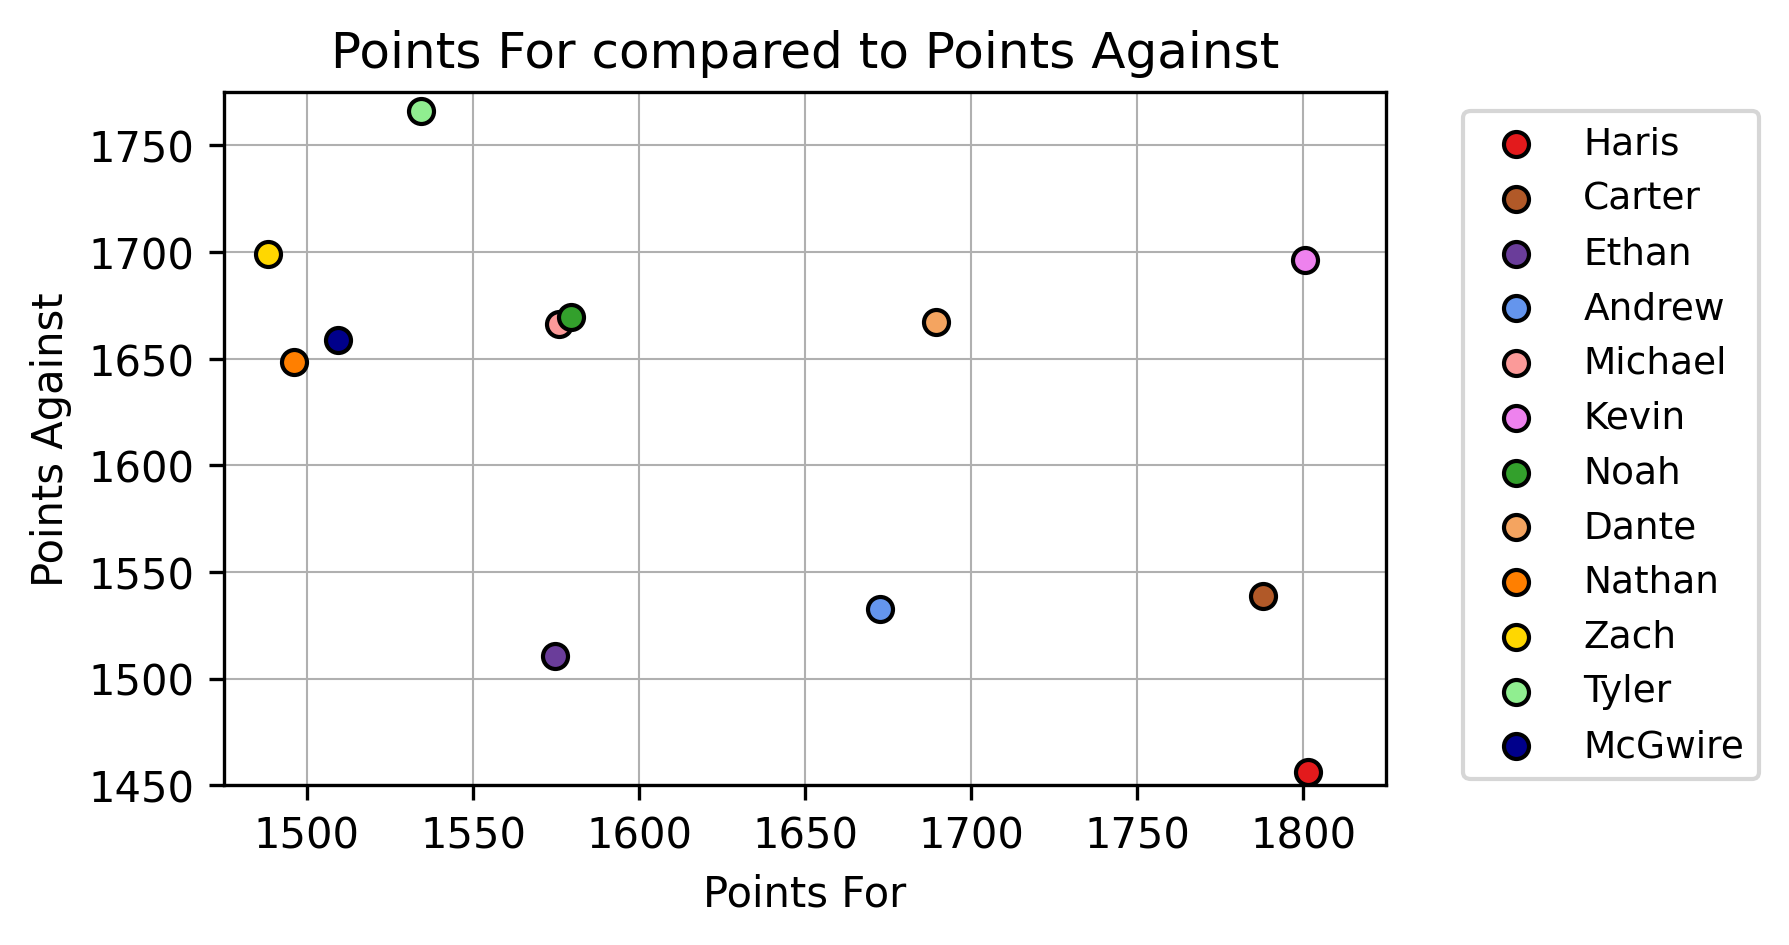

In [ ]:
plt.figure(figsize = (5,3), dpi = 300)
plt.grid(linewidth = 0.5, zorder = 0)
for team, pf, pa, color in s:
    plt.scatter(pf, pa, c = color, label = team, zorder = 3, edgecolor = 'k')
plt.xlim(int(standings['Points For'].min() - 4) - (int(standings['Points For'].min()-4) % 25),
         int(standings['Points For'].max() + 4) + 25 - (int(standings['Points For'].max() + 4) % 25)) # Automatically finds nearest 25 below/above for range
plt.ylim(int(standings['Points Against'].min() - 4) - (int(standings['Points Against'].min() - 4) % 25),
         int(standings['Points Against'].max() + 4) + 25 - (int(standings['Points Against'].max() + 4) % 25))
plt.xlabel('Points For')
plt.ylabel('Points Against')
plt.title('Points For compared to Points Against')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 9)
plt.savefig(f'PF-vs-PA-{year}.svg', format = 'svg', bbox_inches = 'tight')

In [ ]:
GAME_DATA.loc[(~ GAME_DATA['Playoff Flag']) & (GAME_DATA['Year'] == year), 'Week'].max()

np.int64(14)

In [46]:
year = 2020

dfs = []
for week in range(1, GAME_DATA.loc[(~ GAME_DATA['Playoff Flag']) & (GAME_DATA['Year'] == year), 'Week'].max() + 1):
    week_df = summary_table(data=GAME_DATA, year=year, week = week)
    week_df['Week'] = week
    dfs.append(week_df)

season_df = pd.concat(dfs)

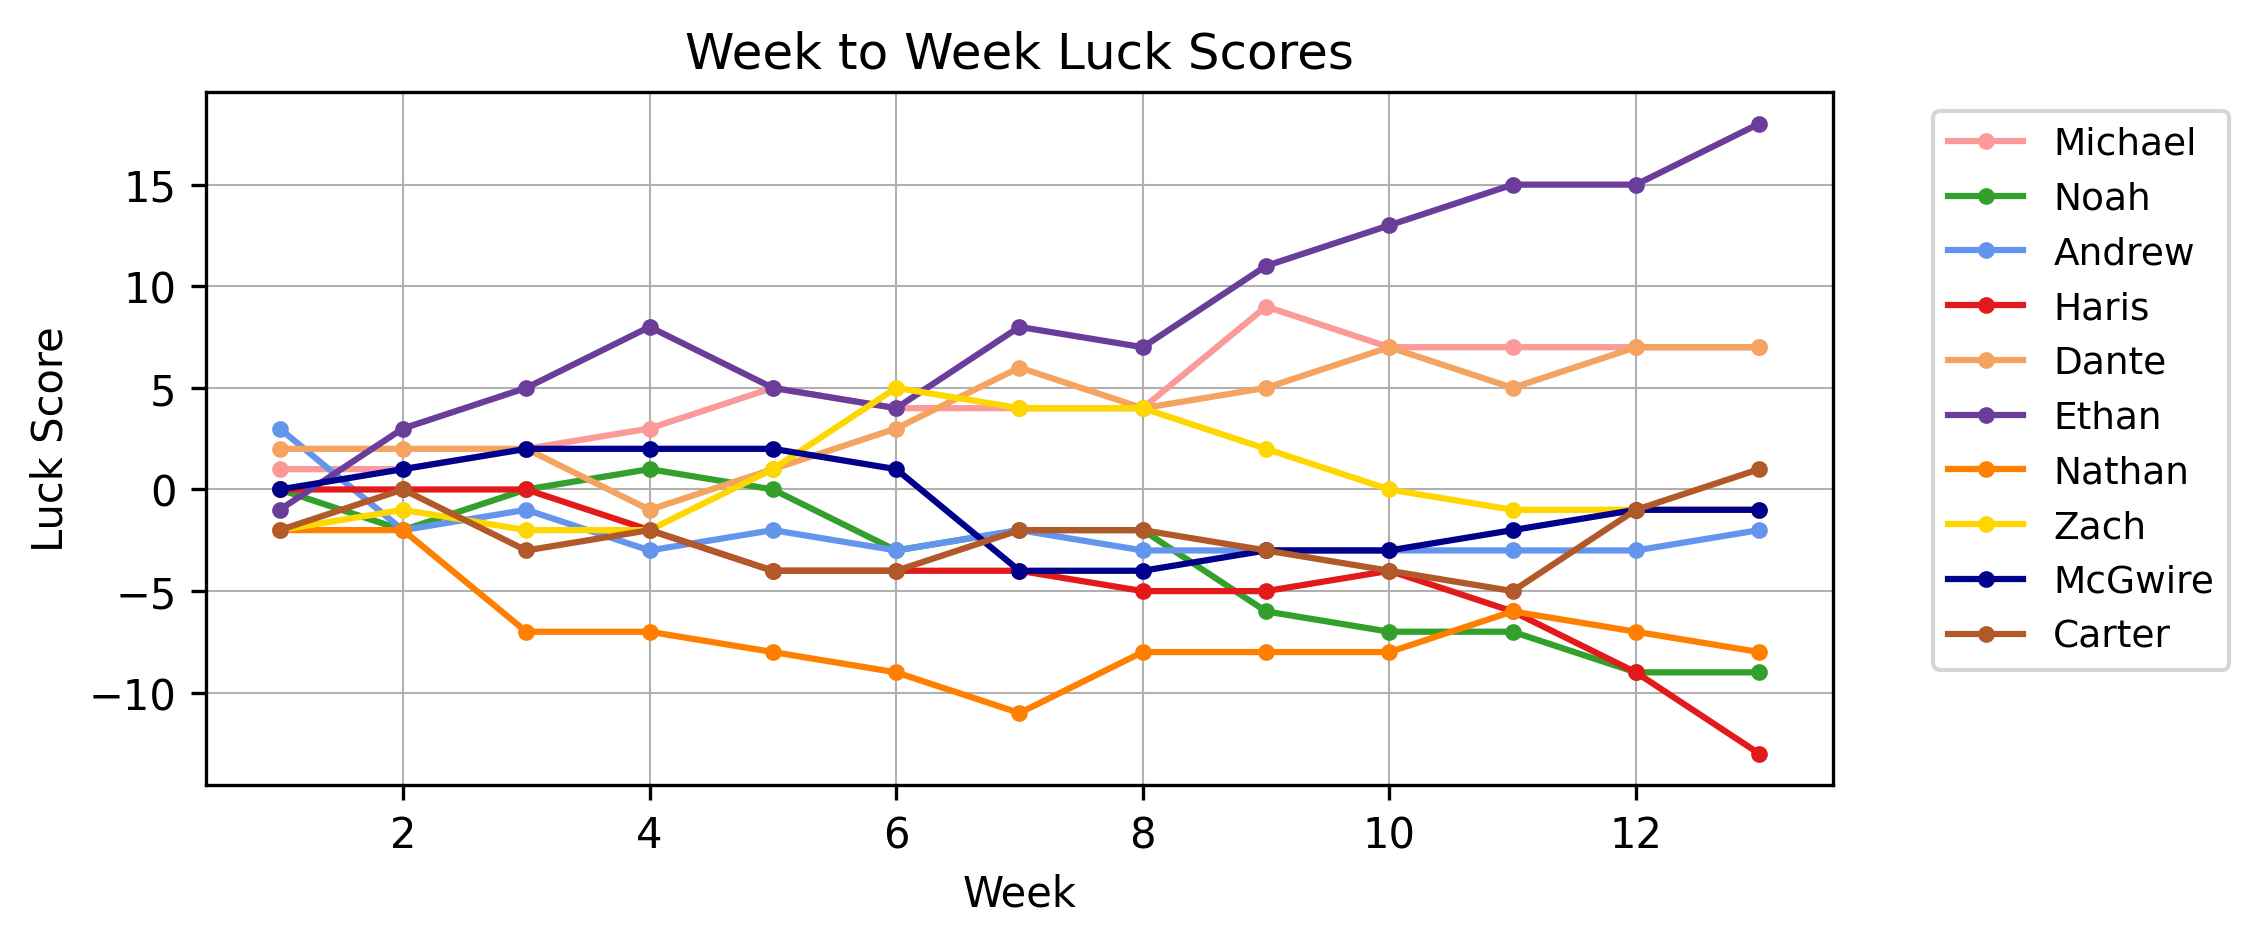

In [47]:
plt.figure(figsize = (7,3), dpi = 300)
plt.grid(linewidth = 0.5, zorder = 0)
for team in season_df['Team'].unique():
    temp_df = season_df.loc[season_df['Team'] == team]
    plt.plot(temp_df['Week'], temp_df['Luck Score'], c = COLOR_DICT[team.lower()], marker = 'o', markersize = 3, label = team, zorder = 3)
plt.xlabel('Week')
plt.ylabel('Luck Score')
plt.title('Week to Week Luck Scores')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 9)

# Playoff Bracket

# Champions Table

In [211]:
champions = df_converted.loc[(df_converted['Week'] == 17) & (df_converted['Win'] == 1), ['Year','Team']].values
champions

array([[2019, 'Dante'],
       [2020, 'Ethan'],
       [2021, 'Andrew'],
       [2022, 'Dante'],
       [2023, 'Haris'],
       [2024, 'Zach']], dtype=object)

In [226]:
data = []
for year, team in champions:
    temp = df_converted.loc[(df_converted['Year'] == year) & (df_converted['Team'] == team) & (df_converted['Playoff Flag'] == False)]
    wins = temp['Win'].sum()
    losses = len(temp) - wins
    record = f'{wins}-{losses}'

    pf = round(temp['Score'].sum(), 2)
    avg_pf = round(pf / len(temp), 2)
    pa = round(temp['Opp Score'].sum(), 2)
    avg_margin = round((pf - pa) / len(temp), 2)

    data.append([year, team, record, pf, avg_pf, avg_margin])
    
pd.DataFrame(data, columns=['Year','Team','Record','Points For','Avg Points For','Avg Margin'])

,Year,Team,Record,Points For,Avg Points For,Avg Margin
0,2019,Dante,8-5,1612.06,124.00,9.25
1,2020,Ethan,11-2,1639.56,126.12,22.44
2,2021,Andrew,10-4,1901.54,135.82,10.45
3,2022,Dante,10-4,1747.00,124.79,12.49
4,2023,Haris,12-2,1801.34,128.67,24.65
5,2024,Zach,8-6,1762.04,125.86,6.56


In [232]:
years = np.arange(2019,2025)
for year in years:
    if year < 2021:
        weeks = np.arange(1,14)
    else:
        weeks = np.arange(1,15)
    print(weeks)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


# Team Content

### Summary table by seasons

In [395]:
seasons = [summary_table(GAME_DATA, year=year) for year in YEARS]
seasons_df = pd.concat(seasons)

seasons_df = seasons_df.loc[seasons_df['Team'] == 'Haris'].drop('Team', axis = 1)
seasons_df

,Year,Record,Ranking,Points For,Points Against,Avg Points For,Avg Margin,Luck Score
4,2019,7-6,5,1548.30,1483.26,119.10,5.00,1
9,2020,3-10,10,1440.82,1773.88,110.83,-25.62,-13
2,2021,8-6,3,1855.22,1655.12,132.52,14.29,4
6,2022,7-7,7,1647.48,1579.54,117.68,4.85,-3
0,2023,12-2,1,1801.34,1456.30,128.67,24.65,10
9,2024,3-11,10,1468.60,1616.88,104.90,-10.59,1


# Entire Season Schedule

In [294]:
team = 'Haris'
year = 2023

all_matchups = MATCHUP_DATA.loc[(MATCHUP_DATA['Home Team'] == team) | (MATCHUP_DATA['Away Team'] == team)]
all_matchups.loc[all_matchups['Year'] == year]

,Unnamed: 0,Year,Week,Playoff Flag,Home Team,Home Score,Home Projection,Away Team,Away Score,Away Projection
330,330,2023,1,False,Haris,133.14,15.85,Noah,105.18,7.95
337,337,2023,2,False,Zach,102.00,112.77,Haris,137.94,115.53
344,344,2023,3,False,Haris,116.06,122.71,Nathan,103.18,121.64
350,350,2023,4,False,Haris,153.28,118.69,Kevin,123.64,114.26
355,355,2023,5,False,Michael,109.04,126.76,Haris,106.90,119.71
360,360,2023,6,False,Haris,89.64,115.07,Carter,103.44,124.69
365,365,2023,7,False,Tyler,121.18,101.39,Haris,123.46,93.45
370,370,2023,8,False,Haris,151.88,115.21,Ethan,97.86,113.72
375,375,2023,9,False,Haris,111.18,112.96,Andrew,94.22,130.10
382,382,2023,10,False,Dante,110.66,119.61,Haris,125.60,120.63


In [28]:
d = div(h2('Title'))

print(d)

s = select(_id='draft-team-filter', onchange='teamFilter()')
options = [option('All', value='all')] + [option(team, value=team.lower()) for team in constants.TEAMS]
s.add(options)

title = d.get(h2)[0]
title.add(s)

print(d)

<div>
  <h2>Title</h2>
</div>
<div>
  <h2>Title
    <select id="draft-team-filter" onchange="teamFilter()">
      <option value="all">All</option>
      <option value="andrew">Andrew</option>
      <option value="nathan">Nathan</option>
      <option value="zach">Zach</option>
      <option value="kevin">Kevin</option>
      <option value="noah">Noah</option>
      <option value="michael">Michael</option>
      <option value="ethan">Ethan</option>
      <option value="dante">Dante</option>
      <option value="justin">Justin</option>
      <option value="klapp">Klapp</option>
      <option value="carter">Carter</option>
      <option value="haris">Haris</option>
      <option value="mcgwire">McGwire</option>
      <option value="tyler">Tyler</option>
    </select>
  </h2>
</div>
